# Demonstration book for Hn-NSF

This is the demonstration book for Hn-NSF. By using this book, we are going to 

* Define a Hn-NSF based on function blocks such as 1D CNN, sine waveform generator
* Load pre-trained Hn-NSF model and generate waveform samples

Details of the functions and blocks are introduced in c*.ipynb.

Note that modules defined in this notebook are also available in `data_models/pre_trained_hn_nsf/model.py`

They are also used in part3 material `../project/01-nsf/hn-nsf/model.py`

## 1. Define Hn-NSF model

Since Hn-NSF is built on the basis of 1D CNN and other NN function blocks. These NN function blocks can be briefly grouped into three modules: the condition module, the source module, and the neural filter module. This section will walk through the general framework of Hn-NSF model.

![Image_1](./figures/fig_s1_1.png)

### 1.1 Preparation

Let's load the packages and basic NN functions:

In [1]:
# At the begining, let's load packages 
from __future__ import absolute_import
from __future__ import print_function
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# load the basic function blocks
# These are the blocks used for this pre-trained model
import data_models.pre_trained_hn_nsf.model as nii_nn_blocks
# Latest modules are in ../sandbox/block_nn.py and ../sandbox/block_nsf.py

# misc functions for this demonstration book
import plot_lib
import tool_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


All the necessary NN function blocks are defined in *data_models/pre_trained_hn_nsf/model.py*

### 1.2 Condition module

![Image_2](./figures/fig_s1_2.png)

The dashed line block shows the network structure of the condition module. This is module has two specific goals: 
1. Up-sample the input F0 sequence
2. Transform and upsample the input acoustic features (e.g., Mel-spec, and F0)

It is straightforward to define the Condition Module

#### Module definition

In [2]:
class CondModule(torch_nn.Module):
    """ Conditiona module
    Upsample and transform input features
    
    Initialization:
    CondModule(input_dim, output_dim, up_sample,
               blstm_s = 64, cnn_kernel_s = 3)
        input_dime: dimension of input features 
        output_dim: dimension of output features for neural filter module
        up_sample: up-sampling rate
        blstm_s: dimension of the hidden Bi-LSTM RNN layer
        cnn_kernel_s: kernel size of the output CNN layer
      
    Method:
    Spec_upsampled, F0_upsampled = CondModule(features, F0)
    
        feature: (batchsize, length, dim)
        f0: (batchsize, length, dim=1), 
        
        spec_upsampled: (batchsize, length * up_sample, output_dim)
        f0_upsampled: (batchsize, length * up_sample, 1)
    
    """
    def __init__(self, input_dim, output_dim, up_sample, \
                 blstm_s = 64, cnn_kernel_s = 3):
        super(CondModule, self).__init__()
        
        # config
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.up_sample = up_sample
        self.blstm_s = blstm_s
        self.cnn_kernel_s = cnn_kernel_s

        # Bi-LSTM layer  (batchsize, length, input_dim) -> (batchsize, length, blsmt_s)
        self.l_blstm = nii_nn_blocks.BLSTMLayer(input_dim, self.blstm_s)
        
        # 1D CNN with stride=1  (batchsize, length, blsmt_s) -> (batchsize, length, output_dim)
        self.l_conv1d = nii_nn_blocks.Conv1dKeepLength(self.blstm_s, output_dim, 1, self.cnn_kernel_s)
        
        # up-sampling layer with smoothing=True 
        # (batchsize, length, output_dim) -> (batchsize, length*up_sample, output_dim)
        self.l_upsamp = nii_nn_blocks.UpSampleLayer(self.output_dim, self.up_sample, True)
        
        # Upsampling for F0: don't smooth up-sampled F0
        self.l_upsamp_F0 = nii_nn_blocks.UpSampleLayer(1, self.up_sample, False)

    def forward(self, feature, f0):
        spec_trans_upsampled = self.l_upsamp(self.l_conv1d(self.l_blstm(feature)))
        f0_upsampled = self.l_upsamp_F0(f0)
        return spec_trans_upsampled, f0_upsampled


#### Example
Let's try some toy examples to show how each layer works

In [3]:
# Create an input feature matrix of size (batchsize, frame_length, feature_dim)
frame_length = 30
feature_dim = 16
batchsize = 2
input_feature = torch.rand(batchsize, frame_length, feature_dim)

# Assume f0 is the last dimension of the input_feature matrix
#  please remember to shape F0 as (batchsize, frame_length, 1), not (batchsize, frame_length)
input_f0 = input_feature[:, :, -1:]

# Initialzie a Condition module, which up-samples input feature for 80 times
# (80 = 16 kHz * 5 ms frame-shift)
output_dim = 16
up_sample = 80
m_cond = CondModule(feature_dim, output_dim, up_sample)

with torch.no_grad():
    spec_upsampled, f0_upsampled = m_cond(input_feature, input_f0)


In [4]:
# Do a simple check
print("Input feature shape: %s" % (str(input_feature.shape)))
print("Output spec-feature shape: %s" % (str(spec_upsampled.shape)))
print("Input F0 shape: %s" % (str(input_f0.shape)))
print("Output F0 shape: %s" % (str(f0_upsampled.shape)))

Input feature shape: torch.Size([2, 30, 16])
Output spec-feature shape: torch.Size([2, 2400, 16])
Input F0 shape: torch.Size([2, 30, 1])
Output F0 shape: torch.Size([2, 2400, 1])


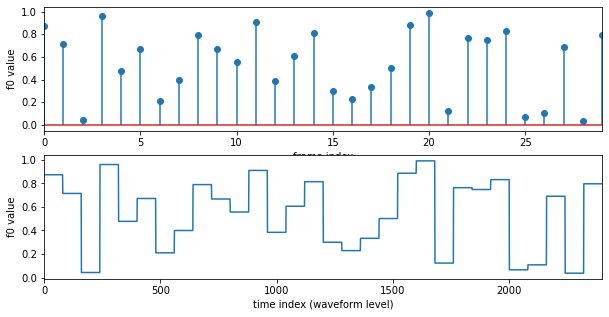

In [5]:
# Plot the F0
fig = plt.figure()
axis = fig.add_subplot(211)
fig, axis = plot_lib.plot_signal_stem(input_f0[0, :, 0].numpy(), fig, axis, "frame index", "f0 value")
axis = fig.add_subplot(212)
fig, axis = plot_lib.plot_signal(f0_upsampled[0, :, 0].numpy(), fig, axis, "time index (waveform level)", "f0 value")

### 1.3 Source Module

![Image_3](figures/fig_s1_3.png)

The input is the up-sampled F0 data $f_{1:N}$ (i.e., one F0 value per one time step $n$); its output includes sine-based excitation signal for harmonic branch. Additionally, we can produce a noise excitation signal for noise branch (not shown in the picture above).

The core part of source module is the generation of phase-continuous sine waveforms.
This core function is implemented in SineGen module (see c9_sine_generator.ipynb). 
Here, I only show the high level definition of the source module.

#### Module definition

In [6]:
# For source module
class SourceModuleHnNSF(torch_nn.Module):
    """ SourceModule for hn-nsf 
    SourceModule(sampling_rate, harmonic_num=0, sine_amp=0.1, 
                 add_noise_std=0.003, voiced_threshod=0)
    sampling_rate: sampling_rate in Hz
    harmonic_num: number of harmonic overtone (default: 0)
    sine_amp: amplitude of sine source signal (default: 0.1)
    add_noise_std: std of additive Gaussian noise (default: 0.003)
        note that amplitude of noise in unvoiced is decided
        by sine_amp
    voiced_threshold: threhold to set U/V given F0 (default: 0)

    Sine_source, noise_source = SourceModuleHnNSF(F0_sampled)
    F0_sampled (batchsize, length, 1)
    Sine_source (batchsize, length, 1)
    noise_source (batchsize, length 1)
    uv (batchsize, length, 1)
    """
    def __init__(self, sampling_rate, harmonic_overtone_num=0, sine_amp=0.1, 
                 add_noise_std=0.003, voiced_threshod=0):
        super(SourceModuleHnNSF, self).__init__()
        
        self.sine_amp = sine_amp
        self.noise_std = add_noise_std

        # to produce sine waveforms
        self.l_sin_gen = nii_nn_blocks.SineGen(
            sampling_rate, harmonic_overtone_num,
            sine_amp, add_noise_std, voiced_threshod)

        # to merge source harmonics into a single excitation
        self.l_linear = torch_nn.Linear(harmonic_overtone_num+1, 1)
        self.l_tanh = torch_nn.Tanh()

        # add a member to save intermediate results
        self.sine_wavs = None
        
    def forward(self, f0_upsampled):
        """
        Sine_source, noise_source = SourceModuleHnNSF(F0_sampled)
        F0_sampled (batchsize, length, 1)
        Sine_source (batchsize, length, 1)
        noise_source (batchsize, length 1)
        """
        # source for harmonic branch
        # generating the fundamental component and harmonic overtones
        sine_wavs, uv, _ = self.l_sin_gen(f0_upsampled)
        self.sine_wavs = sine_wavs
        # merge harmonics into one signal
        sine_merge = self.l_tanh(self.l_linear(sine_wavs))

        # source for noise branch, in the same shape as uv
        noise = torch.randn_like(uv) * self.sine_amp / 3
        return sine_merge, noise, uv


#### Example

For the example, we generate two pairs of source signals in one batch. 

One is a chrip signal; the other is a signal with constant F0.

In [7]:
# Create an up-sample F0 matrix
# Here we try batchsize=2, length=24000
signal_length = 24000
upsampled_f0 = torch.ones(2, signal_length, 1)
# try a chirp signal in the 1st batch (50 - 1000 Hz)
upsampled_f0[0, :, 0] = torch.linspace(50, 1000, signal_length)
# try a constant F0 signal in the 2nd batch (100 Hz)
upsampled_f0[1, :, 0] = 100 

# Create an source module, using 24kHz sampling rate, 3 harmonic overtones
sampling_rate = 24000
harmonic_overtone_num = 2
m_source = SourceModuleHnNSF(sampling_rate, harmonic_overtone_num)

# Generate source signals
with torch.no_grad():
    sine_signal, noise_signal, uv = m_source(upsampled_f0)


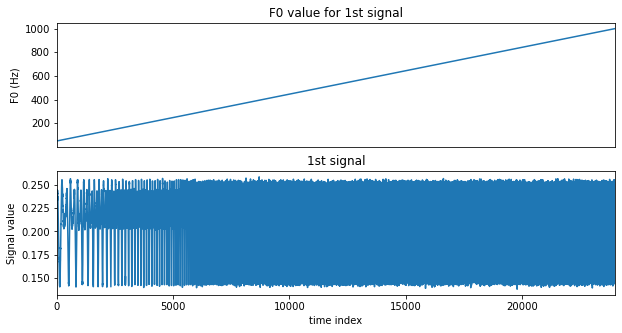

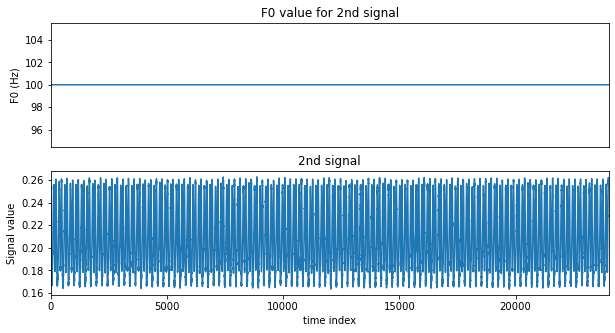

In [8]:
## The first signal

# plot F0 value
fig = plt.figure();
axis = fig.add_subplot(211);
fig, axis = plot_lib.plot_signal(upsampled_f0[0, :, 0], fig, axis, ylabel='F0 (Hz)', title='F0 value for 1st signal')
axis.set_xticks([])
# plot the signal
axis = fig.add_subplot(212);
fig, axis = plot_lib.plot_signal(sine_signal[0, :, 0], fig, axis, xlabel='time index', ylabel='Signal value', title='1st signal')


## The second signal
fig = plt.figure();
axis = fig.add_subplot(211);
fig, axis = plot_lib.plot_signal(upsampled_f0[1, :, 0], fig, axis, ylabel='F0 (Hz)', title='F0 value for 2nd signal')
axis.set_xticks([])
# plot the signal
axis = fig.add_subplot(212);
fig, axis = plot_lib.plot_signal(sine_signal[1, :, 0], fig, axis, xlabel='time index', ylabel='Signal value', title='2nd signal')


In [9]:
import IPython.display
# Play the signals. 
# Just in case, decrease the volumne at first
IPython.display.display(IPython.display.Audio(sine_signal[0, :, 0].numpy(), rate=sampling_rate, normalize=False))
IPython.display.display(IPython.display.Audio(sine_signal[1, :, 0].numpy(), rate=sampling_rate, normalize=False))


Signals above are merged from fundamental component and 7 harmonic overtones.
To see each individual harmonic waveform, we can use the `m_source.sine_wavs`

(0.0, 500.0)

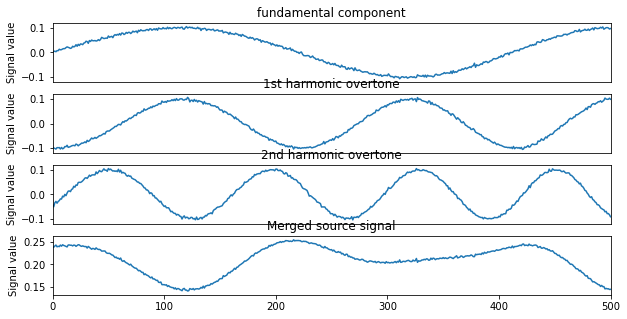

In [10]:
harmonic_idx = [0, 1, 2]
titles = ['fundamental component', '1st harmonic overtone', '2nd harmonic overtone']
fig = plt.figure();
for idx, title in zip(harmonic_idx, titles):
    axis = fig.add_subplot(len(harmonic_idx)+1, 1, idx+1);
    fig, axis = plot_lib.plot_signal(m_source.sine_wavs[0, :, idx], fig, axis, ylabel='Signal value', title=title)
    axis.set_xticks([])
    axis.set_xlim(0, 500)

axis = fig.add_subplot(len(harmonic_idx)+1, 1, len(harmonic_idx)+1);
fig, axis = plot_lib.plot_signal(sine_signal[0, :, 0], fig, axis, ylabel='Signal value', title='Merged source signal')
axis.set_xlim(0, 500)

### 1.4 Neural Fitler Module

![Image_4](figures/fig_s1_4.png)

Neural filter module of Hn-NSF consists of two branches of dilated-CNN-based filter blocks. 
The outputs from the two branches are further processed by high-pass and low-pass digital filters and merged in time domain.

All the filter blocks share the same structure.


#### Definition of a single neural filter block

The filter block in the neural filter module is illustrated blow. Note that there are a few very detailed difference in the actual implementation below, for example, the FF layer on the output side.

Given an input signal $x_{1:N}$, one filter block produces an output signal $y_{1:N}$.

![Image_5](figures/fig_s1_5.png)


In [11]:
# Neural filter block (1 block)
class NeuralFilterBlock(torch_nn.Module):
    """ Wrapper over a single filter block
    """
    def __init__(self, signal_size, hidden_size, \
                 kernel_size=3, conv_num=10):
        super(NeuralFilterBlock, self).__init__()
        # dimension of the input/output signal, which is usually 1
        self.signal_size = signal_size
        # dimension of the hidden features produced by dilated CNN
        self.hidden_size = hidden_size
        # kernel size of the CNN
        self.kernel_size = kernel_size
        # number of dilated 1D conv layers
        self.conv_num = conv_num
        # dilation size
        self.dilation_size = [np.power(2, x) for x in np.arange(conv_num)]

        # definition of the hidden layers
        # 
        # ff layer to expand dimension
        self.l_ff_1 = torch_nn.Linear(signal_size, hidden_size, \
                                      bias=False)
        self.l_ff_1_tanh = torch_nn.Tanh()
        
        # dilated conv layers
        tmp = [nii_nn_blocks.Conv1dKeepLength(
                hidden_size, hidden_size, x, kernel_size, 
                causal=True, bias=False) \
               for x in self.dilation_size]
        self.l_convs = torch_nn.ModuleList(tmp)
        
        # ff layer to de-expand dimension
        self.l_ff_2 = torch_nn.Linear(hidden_size, hidden_size//4,
                                      bias=False)
        self.l_ff_2_tanh = torch_nn.Tanh()
        self.l_ff_3 = torch_nn.Linear(hidden_size//4, signal_size,
                                      bias=False)
        self.l_ff_3_tanh = torch_nn.Tanh()        

        # a simple scale
        # not necessary, just to be consistent with CURRENNT implementation
        self.scale = torch_nn.Parameter(torch.tensor([0.1]), 
                                        requires_grad=False)
        return

    def forward(self, signal, context):
        """ 
        Assume: signal  (batchsize, length, signal_size)
                context (batchsize, length, hidden_size)
        Output: (batchsize, length, signal_size)
        """
        # expand dimension
        tmp_hidden = self.l_ff_1_tanh(self.l_ff_1(signal))
        
        # loop over dilated convs
        # output of a d-conv is input + context + d-conv(input)
        for l_conv in self.l_convs:
            tmp_hidden = tmp_hidden + l_conv(tmp_hidden) + context
            
        # to be consistent with legacy configuration in CURRENNT
        tmp_hidden = tmp_hidden * self.scale
        
        # compress the dimesion and skip-add
        tmp_hidden = self.l_ff_2_tanh(self.l_ff_2(tmp_hidden))
        tmp_hidden = self.l_ff_3_tanh(self.l_ff_3(tmp_hidden))
        output_signal = tmp_hidden + signal
        return output_signal

#### Definition of the neural filter module

It is straightforward to define the neural filter module based on the single neural filter block.

Note that we need to include two pairs of digital filters in the neural filter module:
1. One pair of low- and high-pass filters with cut-off frequency specified for voiced regions
2. One pair of low- and high-pass filters with cut-off frequency specified for unvoiced regions

Details of the FIR digital filters (`TimeInvFIRFilter`) is explained in c5_time_invariant_filter.ipyng. 

The definition here only shows high-level definition.

In [12]:
# For Filter module
class FilterModuleHnNSF(torch_nn.Module):
    """ Filter for Hn-NSF
    FilterModuleHnNSF(signal_size, hidden_size, fir_coef,
                      block_num = 5,
                      kernel_size = 3, 
                      conv_num_in_block = 10)
                      
    signal_size: signal dimension (should be 1)
    hidden_size: dimension of hidden features inside neural filter block
    fir_coef: list of FIR filter coeffs,
              (low_pass_1, low_pass_2, high_pass_1, high_pass_2)
    block_num: number of neural filter blocks in harmonic branch (default 5)
    kernel_size: kernel size in dilated CNN (default 3)
    conv_num_in_block: number of d-conv1d in one neural filter block (default 10)

    Method: 
        output = FilterModuleHnNSF(harmonic_source, noise_source, uv, context)
        
        input:
            harmonic_source (batchsize, length, dim=1)
            noise_source  (batchsize, length, dim=1)
            context (batchsize, length, dim=1)
            uv (batchsize, length, dim=1)

        output: 
            output (batchsize, length, dim=1)    
    """
    def __init__(self, signal_size, hidden_size, filter_coef, \
                 block_num = 5, kernel_size = 3, conv_num_in_block = 10):
        super(FilterModuleHnNSF, self).__init__()
        # similar to the members in NeuralFilterBlock
        self.signal_size = signal_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.block_num = block_num
        self.conv_num_in_block = conv_num_in_block
        
        # A list of FIR filter coefficients
        self.filter_coef = filter_coef

        # filter blocks for harmonic branch
        tmp = [NeuralFilterBlock(signal_size, hidden_size, \
                                 kernel_size, conv_num_in_block) \
               for x in range(self.block_num)]
        self.l_har_blocks = torch_nn.ModuleList(tmp)

        # filter blocks for noise branch (only one block, 5 sub-blocks)
        tmp = [NeuralFilterBlock(signal_size, hidden_size, \
                                 kernel_size, conv_num_in_block // 2) \
               for x in range(1)]
        self.l_noi_blocks = torch_nn.ModuleList(tmp)

        # FIR filter groups
        # lp_v: filter for voiced region, harmonic component
        # lp_u: filter for unvoiced region, harmonic component
        # hp_v: filter for voiced region, noise component
        # hp_u: filter for unvoiced region, noise component
        self.l_fir_lp_v = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[0])
        self.l_fir_lp_u = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[1])
        self.l_fir_hp_v = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[2])
        self.l_fir_hp_u = nii_nn_blocks.TimeInvFIRFilter(signal_size, filter_coef[3])
        
        # For debugging (not necessary for model training or generation)
        self.hidden_signals_har = []
        self.hidden_signals_noi = []
        self.uv = []
        
    def forward(self, har_component, noi_component, condition_feat, uv):
        """
        har_component (batchsize, length, dim=1)
        noi_component (batchsize, length, dim=1)
        condition_feat (batchsize, length, context_dim)
        uv (batchsize, length, dim=1), uv \in (0, 1)
        """
        self.hidden_signals_har = []
        self.hidden_signals_noi = []
        self.uv = []
        
        self.hidden_signals_har.append(har_component)
        # harmonic component
        for l_har_block in self.l_har_blocks:
            har_component = l_har_block(har_component, condition_feat)
            self.hidden_signals_har.append(har_component)
            
        # noise component
        self.hidden_signals_noi.append(noi_component)
        for l_noi_block in self.l_noi_blocks:
            noi_component = l_noi_block(noi_component, condition_feat)
            self.hidden_signals_noi.append(noi_component)
        
        # harmonic + noise in time-domain
        # assume uv is {0, 1}, produce a weight vector for voiced/unvoiced
        # sigmoid is used to avoid {0, 1}, and uv is scaled to {-5, 5}
        w_voi = torch.sigmoid((uv - 0.5) * 10)
        w_unv = 1.0 - w_voi
        
        har_v = self.l_fir_lp_v(har_component)
        har_u = self.l_fir_lp_u(har_component)
        noi_v = self.l_fir_hp_v(noi_component)
        noi_u = self.l_fir_hp_u(noi_component)
        
        output = (har_v + noi_v) * w_voi + (har_u + noi_u) * w_unv
        
        # save results for debugging, not necessary for training/generation
        self.hidden_signals_har.append(har_v)
        self.hidden_signals_har.append(har_u)
        self.hidden_signals_noi.append(noi_v)
        self.hidden_signals_noi.append(noi_u)
        self.uv.append(w_voi)
        return output
        

In the above definition, `self.l_fir_lp_v` and the other three FIR filters are implemented as `TimeInvFIRFilter`. It receives an input tensor for shape (batchsize, length, dim) and produces an output tensor in the same shape (batchsize, length, dim). The frequency responses of the four filters can be plotted using functions in c5_time_invariant_filter.ipynb. Please check that notebook for details.


`output = (har_v + noi_v) * w_voi + (har_u + noi_u) * w_unv` can be interpreted as a binary selection:

* when w_voi[:, t, :] = 1, output[:, t, :] = har_v[:, t, :] + noi_v[:, t, :]
* when w_voi[:, t, :] = 0, output[:, t, :] = har_u[:, t, :] + noi_u[:, t, :]

When w_voi[:, t, :] = 1, `output` receives more input from `har_component`. In the other case,  `output` comes more from `noi_component`. 

In practice, we can do a soft-merge by forcing w_voi and w_unv to be $\in(0, 1)$, through sigmoid function.
```
w_voi = torch.sigmoid((uv - 0.5) * 10)
w_unv = 1.0 - w_voi
...
output = (har_v + noi_v) * w_voi + (har_u + noi_u) * w_unv
```

We will explain the above equation with more details at the end of this notebook.

### 1.5 Define a Hn-NSF

With the source, condition, and filter modules, we can define a Hn-NSF model easily

In [13]:
class Model(torch_nn.Module):
    """ Model definition
    in_dim: dimension of input acoustic features
    out_dim: dimension of output waveform (usually 1)
    sampling_rate: sampling rate of output waveform
    feat_upsamp_rate: up-sampling rate on the input acoustic features
    """
    def __init__(self, in_dim, out_dim, sampling_rate, feat_upsamp_rate):
        super(Model, self).__init__()
        torch.manual_seed(1)
        
        # mean std of input and output features for z-norm
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)
        
        # input and output dimension
        self.input_dim = in_dim
        self.output_dim = out_dim

        ####################################
        # Hyper-parameter configurations
        ####################################
        # amplitude of sine waveform (for each harmonic)
        self.sine_amp = 0.1
        # standard deviation of Gaussian noise for additive noise
        self.noise_std = 0.003
        # dimension of hidden features in filter blocks
        self.hidden_dim = 64
        
        # upsampling rate on input acoustic features (16kHz * 5ms = 80)
        # assume input_reso has the same value
        self.upsamp_rate = feat_upsamp_rate
        
        # sampling rate (Hz)
        self.sampling_rate = sampling_rate
        
        # CNN kernel size in filter blocks
        self.cnn_kernel_size = 3
        # number of filter blocks (for harmonic branch)
        # noise branch only uses 1 block
        self.filter_block_num = 5
        # number of dilated CNN in each filter block
        self.cnn_num_in_block = 10
        # number of harmonic overtone in source
        self.harmonic_num = 7

        ##########################################
        # FIR filter definition
        ##########################################
        # fixed filter coefficients
        # computed using PM algorithm 
        # (tool: http://t-filter.engineerjs.com)
        #
        # low-pass for harmonic-component in voiced region
        #  16kHz, pass-band 0-5K, gain 1, ripple 5dB, 
        #         stop-band 7-8k, gain 0, ripple -40dB)
        lp_v = [0.08538414199291068, 0.04920229475534168,-0.1470178606967731, 0.24737764593887432,0.7103067853166558, 0.24737764593887432,-0.1470178606967731, 0.04920229475534168,0.08538414199291068]

        # low-pass for harmonic-copmonent in unvoiced region
        #  16kHz, pass-band 0-1K, gain 1, ripple 5dB, 
        #         stop-band 3-8k, gain 0, ripple -40dB)
        lp_u = [0.00936455546502, 0.0416254862901, 0.0878313219556,0.146086321198, 0.192602581136, 0.211221591449,0.192602581136, 0.146086321198, 0.0878313219556,0.0416254862901, 0.00936455546502]

        # high-pass for noise-component in voiced region
        #  16kHz, pass-band 7-8K, gain 1, ripple 5dB, 
        #         stop-band 0-5k, gain 0, ripple -40dB)        
        hp_v = [-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122,-0.19260258113649556, 0.21122159144894015,-0.19260258113649556, 0.1460863211980122,-0.08783132195564508, 0.04162548629009957,-0.00936455546502148]

        # high-pass for noise-component in unvoiced region
        #  16kHz, pass-band 3-8K, gain 1, ripple 5dB, 
        #         stop-band 0-1k, gain 0, ripple -40dB)                
        hp_u = [0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929]
        
        self.fir_filters = [torch.tensor(lp_v), torch.tensor(lp_u),
                            torch.tensor(hp_v), torch.tensor(hp_u)]
        
        ##############################
        # the three modules
        ##############################
        self.m_condition = CondModule(
            self.input_dim, self.hidden_dim, self.upsamp_rate, \
            cnn_kernel_s = self.cnn_kernel_size)

        self.m_source = SourceModuleHnNSF(
            self.sampling_rate, self.harmonic_num, self.sine_amp, self.noise_std)
        
        self.m_filter = FilterModuleHnNSF(
            self.output_dim, self.hidden_dim, self.fir_filters, \
            self.filter_block_num, self.cnn_kernel_size, self.cnn_num_in_block)
        
        # done
        return
    
    def prepare_mean_std(self, in_dim, out_dim):
        in_m = torch.zeros([in_dim])
        in_s = torch.zeros([in_dim])
        out_m = torch.ones([out_dim])
        out_s = torch.ones([out_dim])
        return in_m, in_s, out_m, out_s
        
    def normalize_input(self, x):
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        return (y - self.output_mean) / self.output_std

    def denormalize_output(self, y):
        return y * self.output_std + self.output_mean
    
    def forward(self, x):
        """ definition of forward method 
        Assume x (batchsize, length, dim)
        Return output(batchsize, length)
        """
        # assume x[:, :, -1] is F0
        f0 = x[:, :, -1:]
        
        # normalize the input features
        feat = self.normalize_input(x)

        # condition module
        # features_for_filter_block, up-sampled F0
        cond_feat, f0_upsamped = self.m_condition(feat, f0)
        
        # source module
        # harmonic-source, noise-source (for noise branch), uv flag
        har_source, noi_source, uv = self.m_source(f0_upsamped)
        
        # filter module (including FIR filtering)
        # output signal
        output = self.m_filter(har_source, noi_source, cond_feat, uv)
        
        # output
        return output.squeeze(-1)

## 2. Using pre-trained model for generation

Here we demonstrate how the model works by generating some waveforms from a pre-trained model.
We are going to

1. Declare a model, load model weights from a pre-trained model
2. Load input data and generate waveform samples

### 2.1 Model declare

In [14]:
# input feature dim (80 dimension Mel-spec + 1 dimension F0)
mel_dim = 80
f0_dim = 1
input_dim = mel_dim + f0_dim

# output dimension = 1 for waveform
output_dim = 1
# sampling rate of waveform (Hz)
sampling_rate = 16000
# up-sampling rate of acoustic features (sampling_rate * frame_shift)
feat_upsamp_rate = int(16000 * 0.005)

# declare the model
hn_nsf_model = Model(input_dim, output_dim, sampling_rate, feat_upsamp_rate)

In [15]:
# load pre-trained model
device=torch.device("cpu")
hn_nsf_model.to(device, dtype=torch.float32)
checkpoint = torch.load("data_models/pre_trained_hn_nsf/trained_network.pt", map_location="cpu")
hn_nsf_model.load_state_dict(checkpoint)

<All keys matched successfully>

### 2.2 Load waveform, extract input features, and generate waveform

We extract a Mel-spectrogram and F0 sequence from input waveform. When these two features are extracted using different tools, it is possible that they have different length because of the implementation of those tools. In such case, please either trim or pad the feature sequences. Here we trim one frame of Mel-spectrogram.

Let's use CPU.

#### Extract Mel and F0

In [16]:
# If you want to do copy-synthesis
# The tools to extract are in data_models/scripts
import sys
import os
sys.path.append(os.path.sep.join([os.getcwd(), 'data_models', 'scripts', 'f0_yaapt']))
import data_models.scripts.sub_get_mel as nii_mel_tk
import data_models.scripts.f0_yaapt.get_f0 as nii_f0_tk

sampling_rate = 16000
fftl_n = 1024
frame_length = 400
frame_shift = 80
frame_length_in_ms = int(frame_length*1000/sampling_rate)
frame_shift_in_ms = int(frame_shift*1000/sampling_rate)

input_waveform_path = "data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav"
input_mel = nii_mel_tk.get_melsp(input_waveform_path, fftl=fftl_n, fl=frame_length, fs=frame_shift)
input_f0 = nii_f0_tk.extractF0_wrapper(input_waveform_path, frame_length=frame_length_in_ms, 
                                       frame_shift=frame_shift_in_ms)



In [17]:
# If you have problem running the code above, please just load the pre-extracted features

#input_mel = tool_lib.read_raw_mat("data_models/acoustic_features/hn_nsf/slt_arctic_b0474.mfbsp", mel_dim)
#input_f0 = tool_lib.read_raw_mat("data_models/acoustic_features/hn_nsf/slt_arctic_b0474.f0", f0_dim)


In [18]:
print("Input Mel shape:" + str(input_mel.shape))
print("Input F0 shape:" + str(input_f0.shape))

# compose the input tensor
input_length = min([input_mel.shape[0], input_f0.shape[0]])
input_tensor = torch.zeros(1, input_length, mel_dim + f0_dim, dtype=torch.float32)
input_tensor[0, :, 0:mel_dim] = torch.tensor(input_mel[0:input_length, :])
input_tensor[0, :, mel_dim:] = torch.tensor(input_f0[0:input_length]).unsqueeze(-1)

print("Input data tensor shape:" + str(input_tensor.shape))

Input Mel shape:(554, 80)
Input F0 shape:(549,)
Input data tensor shape:torch.Size([1, 549, 81])


#### Generate waveform

In [19]:
with torch.no_grad():
    output_waveform = hn_nsf_model(input_tensor)

In [20]:
import IPython.display
IPython.display.Audio(output_waveform[0].numpy(), rate=sampling_rate, normalize=False)

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15551c0e6e50>)

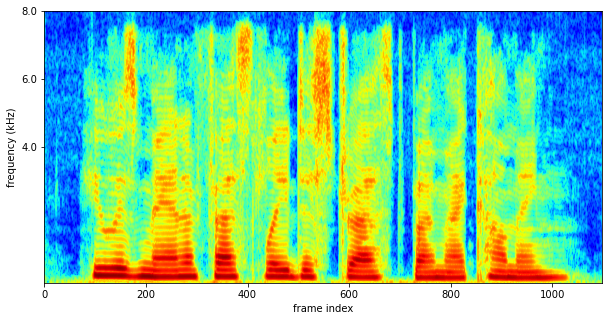

In [21]:
# plot the spectrogram of the generated waveform
spectrogram = tool_lib.spec_amplitude(output_waveform[0].numpy(), fft_bins=4096, frame_shift=40, frame_length=240)
fig=plt.figure(); axis=fig.add_subplot(111);
plot_lib.plot_spectrogram(spectrogram, fig, axis, "frame index", "frequency (kHz)", sampling_rate = sampling_rate)


You may also try other waveforms in `data_models/acoustic_features/hn_nsf`. 


Note that waveforms I used to train this WaveNet have normalized  amplitude. The normalization tool is the sv56 https://github.com/openitu/STL. If you try part3 of this tutorial and run the script `../project/01-nsf/*/00_demo.sh`, you will download the normalized waveforms of CMU-arctic. There will also be a script to use sv56 `../project/01-nsf/DATA/cmu-arctic-data-set/scripts/wav`. But please compile the sv56 and sox first. 

## 3. Analyzing the hidden signals

Neural filter blocks in NSF models takes 1-dimensional signal as input and produces 1-dimensional signal as output. The skip-connection inside the neural filter blocks allows the neural filter module to gradually transform the source signal into the output signal.

Here we plot the figures for the hidden signals. We use the buffer inside the `FilterModuleHnNSF`

1. `hn_nsf_model.m_filter.hidden_signals_har`: the hidden signals in the harmonic branch
2. `hn_nsf_model.m_filter.hidden_signals_noi`: the hidden signals in the noise branch

For convenience, here is a wrapper function for plotting waveform and spectrogram.

In [22]:
def plot_signal_and_spec(signal_list, name_buffer, sampling_rate):
    # to get spectrogram
    f_spec_function = lambda x: tool_lib.spec_amplitude(x, fft_bins=4096, frame_shift=40, frame_length=240)
    
    # 
    fig = plt.figure(figsize=(10, len(name_buffer)*2));
    for idx, (signal, signal_name) in enumerate(zip(signal_list, name_buffer)):
        signal_tmp = signal
        # 
        axis = fig.add_subplot(len(name_buffer), 2, idx * 2 + 1)
        plot_lib.plot_signal(signal_tmp, fig, axis, 'time step', 'waveform value', signal_name)
        if idx < (len(name_buffer)-1):
            axis.set_xticks([]);axis.set_xlabel('')

        spec = f_spec_function(signal_tmp)
        axis = fig.add_subplot(len(name_buffer), 2, idx * 2 + 2)
        plot_lib.plot_spectrogram(spec, fig, axis, "frame index", "frequency (kHz)", sampling_rate = sampling_rate)
        if idx < (len(name_buffer)-1):
            axis.set_xticks([]);axis.set_xlabel('')

        IPython.display.display(signal_name)
        IPython.display.display(IPython.display.Audio(signal_tmp, rate=sampling_rate, normalize=False))

### 3.1 plot hidden signals (in harmonic branch)

![images_4_2](./figures/fig_s1_4_2.png)

We first plot the sine-source signal $e_{1:N}$ and the output from the 5 filter blocks in the figure above


'sine-source'

'1st neural filter block'

'2nd neural filter block'

'3rd neural filter block'

'4th neural filter block'

'5th neural filter block'

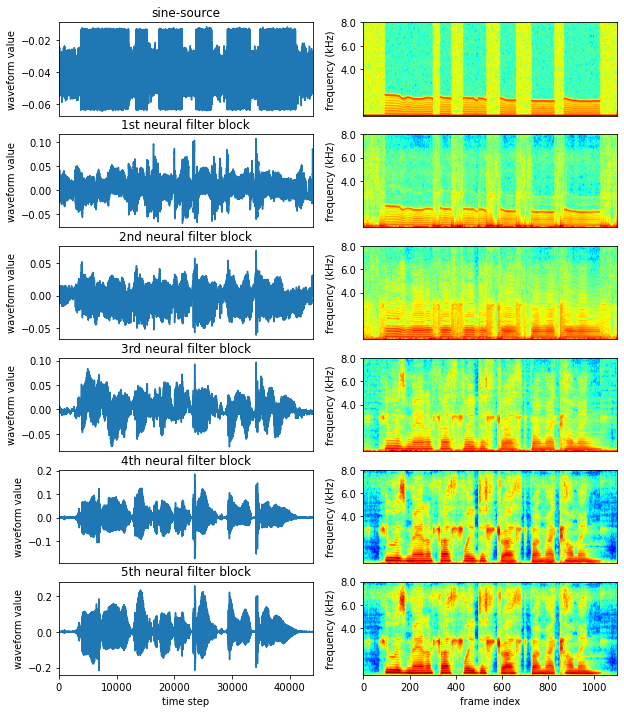

In [23]:
# For harmonic branch
name_buffer = ['sine-source', 
               '1st neural filter block', 
               '2nd neural filter block', '3rd neural filter block',
               '4th neural filter block', '5th neural filter block']
# convert from (batch, length, din) to numpy array
signal_list = [x[0, :, 0].numpy() for x in hn_nsf_model.m_filter.hidden_signals_har]
# plot
plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

From the figures, we can see how the harmonic branch gradually change the spectra of the hidden signals.

Notice that the output of the block 5 still contains high-frequency noises. These high-frequency noises will be filtered out by the loss-pass filters. We will come back to this topic later.

### 3.2 hidden signals in noise branch
For now, let us also check the noise branch:

![images_4_3](./figures/fig_s1_4_3.png)


'noise-source'

'1st neural filter block'

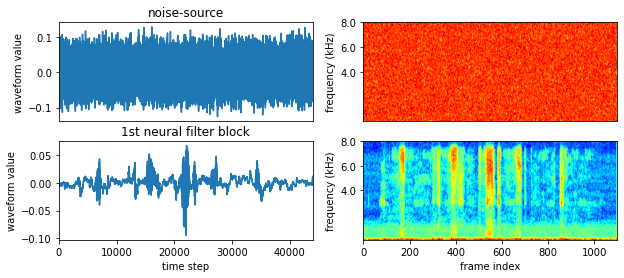

In [24]:
# For noise branch
name_buffer = ['noise-source', '1st neural filter block']
signal_list = [x[0, :, 0].numpy() for x in hn_nsf_model.m_filter.hidden_signals_noi]
plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

For noise branch, we can see how the filter block changes the spectra of the hidden signal.

### 3.3 FIR filters

Figures of Hn-NSF to far doesn't show the full details of the implementation on the FIR filtering part (due to limited space). 

In practice, the low- and high-pass filters in the voiced and unvoiced regions are used in this way:

![images_6](./figures/fig_s1_6.png)

The voiced? or unvoiced? flag can be easily retrieved from the F0 trajectory $f_{1:N}$.
In practice, we use `w_voi` as voiced?, `w_unv` as unvoiced?.

Now, let's plot the input and output of the filters.

#### Harmonic branch

Here we plot:
1. the input to the lp filters (i.e., output of the 5th filter block in harmonic branch)
2. output of the lp-v filter
3. output of the lp-u filter

![images_6_2](./figures/fig_s1_6_2.png)

'input to lp filters'

'output of lp_u'

'output of lp_v'

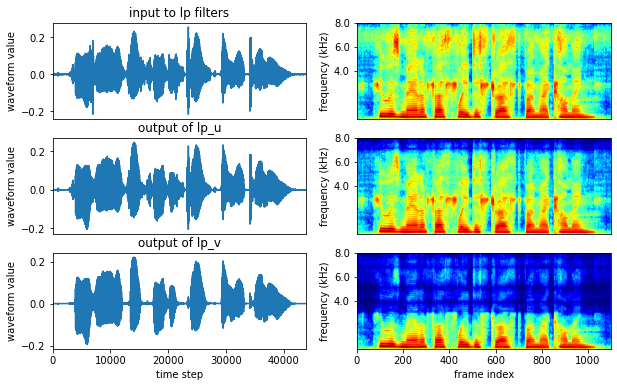

In [25]:
name_buffer = ['input to lp filters', 'output of lp_u', 'output of lp_v']

# get the signals
har_input = hn_nsf_model.m_filter.hidden_signals_har[-3][0, :, 0].numpy()
har_v = hn_nsf_model.m_filter.hidden_signals_har[-2][0, :, 0].numpy()
har_u = hn_nsf_model.m_filter.hidden_signals_har[-1][0, :, 0].numpy()
signal_list = [har_input, har_v, har_u] 

plot_signal_and_spec(signal_list, name_buffer, sampling_rate)


As above figures show, output of lp_v filter has energy above 4kHz, while output of lp_u is only up to 3kHz.

This is expected because lp_v and lp_u have cut-off frequencies around 7 kHz and 3 kHz, respectively.  


#### Noise branch

Similarly, we can plot the figures for the noise branch

![images_6_3](figures/fig_s1_6_3.png)

'input to hp filters'

'output of hp_u'

'output of hp_v'

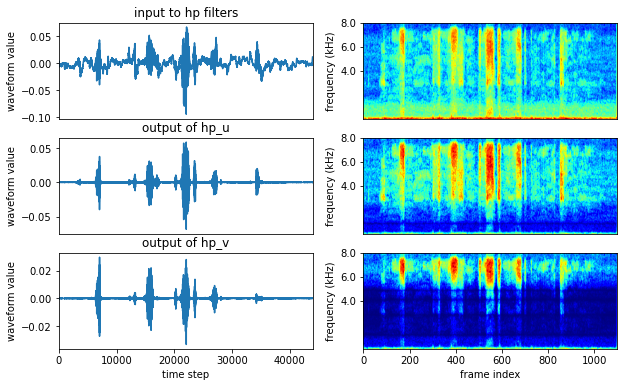

In [26]:
name_buffer = ['input to hp filters', 'output of hp_u', 'output of hp_v']

# get the signals
noi_input = hn_nsf_model.m_filter.hidden_signals_noi[-3][0, :, 0].numpy()
noi_v = hn_nsf_model.m_filter.hidden_signals_noi[-2][0, :, 0].numpy()
noi_u = hn_nsf_model.m_filter.hidden_signals_noi[-1][0, :, 0].numpy()
signal_list = [noi_input, noi_u, noi_v]

plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

Output of hp_v has energy from 6kHz to 8kHz, while that in hp_u has a wider spectral range

#### Merge signals

We have mentioned how to merge the outputs from the two pairs of low- and high-pass filters.

```
w_voi = torch.sigmoid((uv - 0.5) * 10)
w_unv = 1.0 - w_voi
...
output = (har_v + noi_v) * w_voi + (har_u + noi_u) * w_unv
```

There are different ways to explain the equation. 

Let's first consider
`output = (har_v * w_voi + har_u * w_unv) + (noi_v * w_voi + noi_u * w_unv)`


'harmoic filtered'

'noise filtered'

'harmonic + noise'

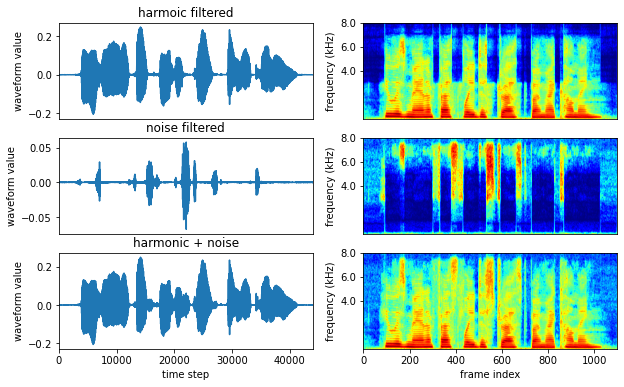

In [27]:
w_voi = hn_nsf_model.m_filter.uv[0][0, :, 0].numpy()
w_unv = 1.0-hn_nsf_model.m_filter.uv[0][0, :, 0].numpy()

har = har_v * w_voi + har_u * w_unv
noi = noi_v * w_voi + noi_u * w_unv
name_buffer = ['harmoic filtered', 'noise filtered', 'harmonic + noise']
signal_list = [har, noi, har+noi]

plot_signal_and_spec(signal_list, name_buffer, sampling_rate)

It is easy to see that the `har` contributes more to the voiced regions while `noi` contributes to the unvoiced regions. But summing them together, we get the final output.


## Final note

Scripts to train hn-nsf and other NSF models on CMU-Arctic database are available in `../project/01-nsf`

Papers and many more samples can be found on NSF home page https://nii-yamagishilab.github.io/samples-nsf/

The end